# New and notable tskit features

Our contributor community is active: tskit is being constantly improved by contributors from around the world.
These constantly change the featureset of tskit, bug fixes, improvements to the efficiency of existing features.
This notebook will demonstrate a small subset of the features that were added to tskit in 2022:

In [1]:
import msprime # used to generate datasets
import tskit
import numba # used in the 'efficient array access' section
import numpy as np
import matplotlib.pyplot as plt # used for plots in tree balance section

Test data we'll use:

In [2]:
ts = msprime.sim_ancestry( # 1Mb human-ish tree sequence
            samples=1e4,
            sequence_length=1e6,
            random_seed=408,
            recombination_rate=1e-8,
            population_size = 10000
)
t = ts.first() # big tree

ts0 = msprime.sim_ancestry( # small tree sequence
            samples=2,
            sequence_length=10,
            random_seed=107,
            recombination_rate=0.01
)
t0 = ts0.first() # small tree

In [3]:
print(ts.num_trees)
print(ts0.num_trees)

3880
3


## Efficient array access

*GT notes: For poster purposes, the most important code cells here are 3, 4, 6, 8, 9*

Relationships between nodes in individual trees can now be extracted as `numpy` arrays.

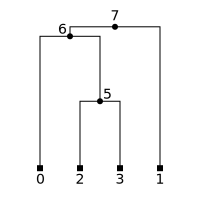

In [4]:
t0.draw()

For example, the `parent_array` is an array that lists, at position i, the parent of the ith node in the tree. In the parent array obtained from the tree `t0`, the 2nd and 3rd elements are 5 because sample nodes 2 and 3 are immediate descendants of node 5. The 4th element is -1 because node 4 is not present in `t0`.

In [5]:
t0.parent_array

array([ 6,  7,  5,  5, -1,  6,  7, -1, -1], dtype=int32)

This method is **fast and efficient**: on the order of nanoseconds for a tree with 10s of 1000s of samples!

In [6]:
%%timeit

t.parent_array

74.7 ns ± 11 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


When used in conjunction with the `numba` package,
these arrays make it possible to write Python-based calculations on the trees that run as speedily as machine-level code.
For instance, suppose we want to calculate the total branch length of our trees.
There are straightforward ways to do this in Python using `tskit`'s existing iterators, like this:

In [7]:
%%timeit

total_py = sum(t.branch_length(u) for u in t.nodes())

26 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


There is also an inbuilt `tskit` function called `total_branch_length`. It is significantly faster because it runs in C:

In [8]:
%%timeit

total_tskit = t.total_branch_length

388 µs ± 9.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Here is an function using `numba` that performs the same calculation. Having the `parent_array` is **key** here, as numba works most efficiently when it is fed numpy arrays as input.

In [9]:
@numba.njit
def _total_branch_length(preorder, parent, node_time):
     tbl = 0
     for u in preorder:
          if parent[u] != -1:
               tbl += node_time[parent[u]] - node_time[u]
     return tbl

def get_total_branch_length(tree):
     return _total_branch_length(tree.preorder(), tree.parent_array, tree.tree_sequence.nodes_time)
    
get_total_branch_length(t0)

5.742542015210538

How long does it take to run this on a tree with 10s of 000s of samples? Let's see:

In [10]:
%%timeit

total_numba = get_total_branch_length(t)

405 µs ± 2.12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Consider what we've just done: written some Python code that runs in about the same time as a (much more complicated and fiddly) C function!

Many other calculations like this are possible using `tskit`'s new suite of tree array methods.
See others, including: `left_child_array`, `left_child_array`, `right_child_array`,`left_sib_array`, `right_sib_array`...

## Tree balance metrics

A balanced (binary) tree is perfectly symmetric in some way: each node has an equally sized subtree descending from its left- and right- branches, where 'size' is determined via some metric involving numbers of nodes and/or lengths of branches. (is this a good definition???)
`tskit` now contains several different metrics to calculate how unbalanced each tree is: `b1`, `b2`, `colless` and `sackin` (references for these?)

In [11]:
b1 = [tree.b1_index() for tree in ts.trees()]

In [12]:
b2 = [tree.b2_index() for tree in ts.trees()]

In [13]:
colless = [tree.colless_index() for tree in ts.trees()]

In [14]:
sackin = [tree.sackin_index() for tree in ts.trees()]

In [15]:
def normalise_metric(in_values):
    mean_val = np.mean(in_values)
    std_val = np.std(in_values)
    return (in_values - mean_val)/std_val

b1_n = normalise_metric(b1)
b2_n = normalise_metric(b2)
colless_n = normalise_metric(colless)
sackin_n = normalise_metric(sackin)

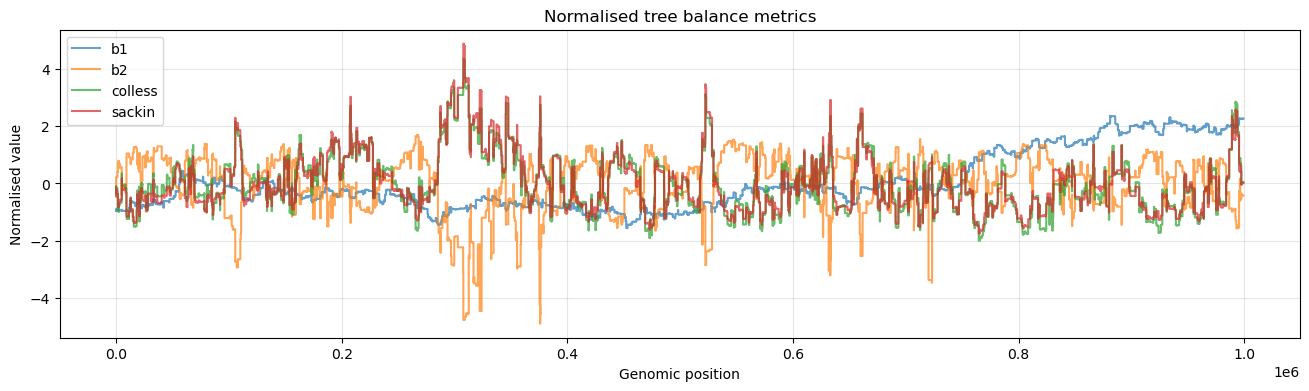

In [16]:
x = [tree.interval.left for tree in ts.trees()]

fig, ax = plt.subplots(1, figsize=(16, 4))
ax.grid(axis='y', color='grey', alpha=0.2)
ax.grid(axis='x', color='grey', alpha=0.2)
ax.step(x, b1_n, label='b1', alpha=0.7)
ax.step(x, b2_n, label='b2', alpha=0.7)
ax.step(x, colless_n, label='colless', alpha=0.7)
ax.step(x, sackin_n, label='sackin', alpha=0.7)
ax.set_title("Normalised tree balance metrics")
ax.set_xlabel("Genomic position")
ax.set_ylabel("Normalised value")
ax.legend()

## Reference sequence and alignments

## Structural operations